In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('../dataset/XSS_dataset_3030.csv', encoding='utf-8-sig')
df.head()

,No,Sentence,Label
0,0,<h2><span class=mw-headline id=see_also>see also,0
1,1,<li><a href=/wiki/philosophy_of_biology title=...,0
2,2,<html oncopy=alert(1) contenteditable>test</html>,1
3,3,/image,0
4,4,file_name=><script>alert('hacked b<br/>y turkp...,1


In [3]:
def data2char_index(X, max_len):
    alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]\{\}"
    result = [] 
    for data in X:
        mat = []
        for ch in data:
            if ch not in alphabet:
                continue
            mat.append(alphabet.index(ch))
        result.append(mat)   
    X_char = tf.keras.preprocessing.sequence.pad_sequences(np.array(result, dtype=object), padding='post',
                                                           truncating='post', maxlen=max_len)
    return X_char

In [4]:
data = df['Sentence'].values
label = df['Label'].values

trainX, testX, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

x_train = data2char_index(trainX, max_len=1000)
x_test = data2char_index(testX, max_len=1000)

In [5]:
x_train.shape
x_test.shape

(12000, 1000)

In [6]:
def get_charcnn_model(max_len):
    main_input = tf.keras.layers.Input(shape=(max_len,))
    
    embedder = tf.keras.layers.Embedding(
        input_dim=70,  
        output_dim=80, 
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)
    
    cnn1 = tf.keras.layers.Conv1D(32, 5, padding='same', strides=1, activation='relu')(embed)
    cnn1 = tf.keras.layers.MaxPooling1D(pool_size=12)(cnn1)
    
    cnn2 = tf.keras.layers.Conv1D(32, 10, padding='same', strides=1, activation='relu')(embed)
    cnn2 = tf.keras.layers.MaxPooling1D(pool_size=11)(cnn2)
    
    cnn3 = tf.keras.layers.Conv1D(32, 15, padding='same', strides=1, activation='relu')(embed)
    cnn3 = tf.keras.layers.MaxPooling1D(pool_size=10)(cnn3)
    
    cnn = tf.keras.layers.concatenate([cnn1, cnn2, cnn3], axis=1)
    flat = tf.keras.layers.Flatten()(cnn)
    drop = tf.keras.layers.Dropout(0.2)(flat)
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(drop)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
    main_output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    model = tf.keras.Model(inputs=main_input, outputs=main_output)
    return model

In [7]:
model = get_charcnn_model(max_len=1000)
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1000, 80)     5600        ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 1000, 32)     12832       ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1000, 32)     25632       ['embedding[0][0]']              
                                                                                              

In [8]:
batch_size = 1024
num_epoch = 10
model_log = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=num_epoch,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/10
47/47 [==============================] - 35s 615ms/step - loss: 0.3024 - accuracy: 0.8559 - val_loss: 0.0140 - val_accuracy: 0.9958
Epoch 2/10
47/47 [==============================] - 25s 526ms/step - loss: 0.0078 - accuracy: 0.9976 - val_loss: 0.0044 - val_accuracy: 0.9991
Epoch 3/10
47/47 [==============================] - 25s 528ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0024 - val_accuracy: 0.9994
Epoch 4/10
47/47 [==============================] - 25s 526ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0014 - val_accuracy: 0.9998
Epoch 5/10
47/47 [==============================] - 25s 527ms/step - loss: 8.4684e-04 - accuracy: 0.9999 - val_loss: 0.0011 - val_accuracy: 0.9998
Epoch 6/10
47/47 [==============================] - 25s 524ms/step - loss: 5.9954e-04 - accuracy: 0.9999 - val_loss: 8.5427e-04 - val_accuracy: 0.9998
Epoch 7/10
47/47 [==============================] - 25s 527ms/step - loss: 4.0992e-04 - accuracy: 1.0000 - val_loss: 6.7738e-04 - 

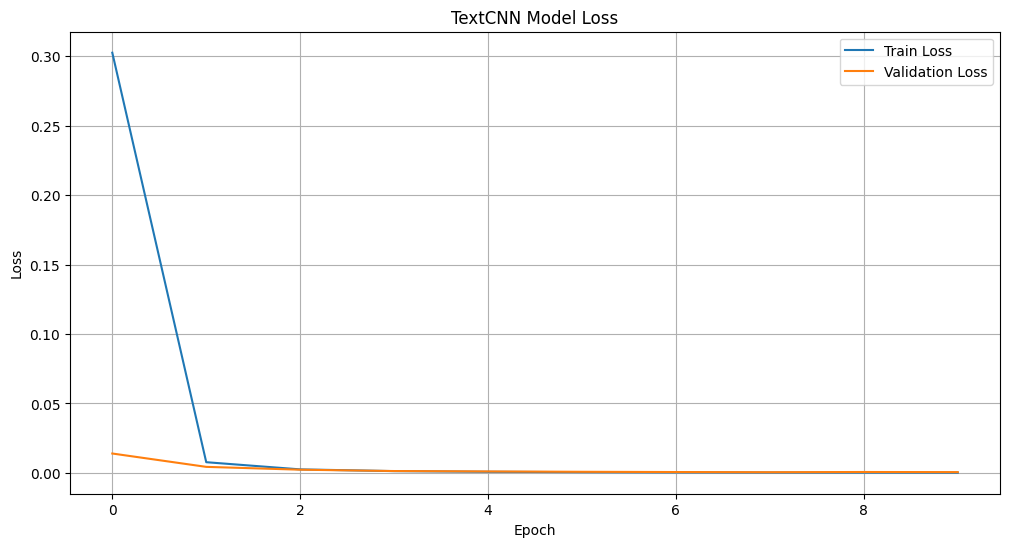

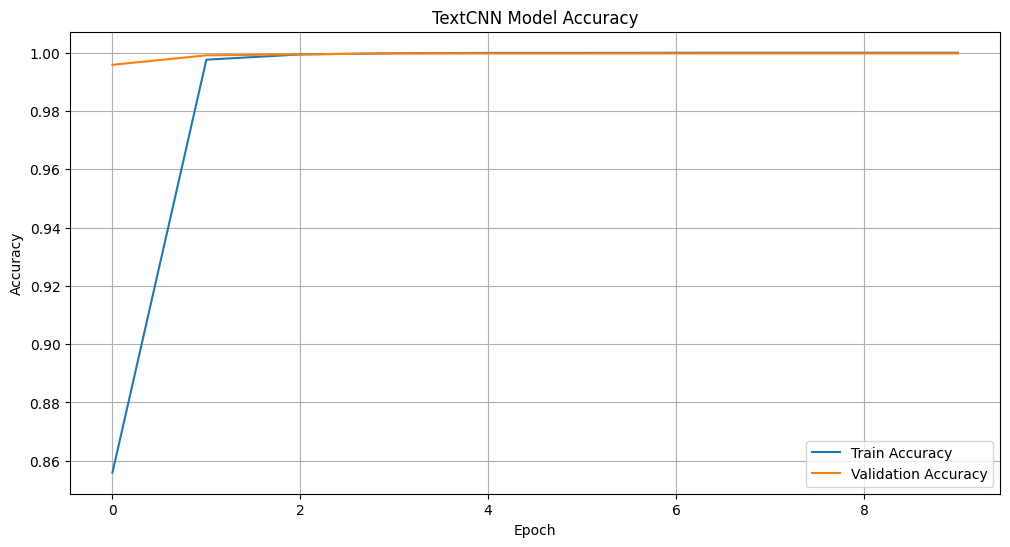

In [9]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['loss'], label='Train Loss')
plt.plot(model_log.history['val_loss'], label='Validation Loss')
plt.title('TextCNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Vẽ biểu đồ Accuracy
plt.figure(figsize=(12, 6))
plt.plot(model_log.history['accuracy'], label='Train Accuracy')
plt.plot(model_log.history['val_accuracy'], label='Validation Accuracy')
plt.title('TextCNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [17]:
# model.save("../web/models/TextCNN.keras")
#loaded_model = keras.models.load_model("../web/models/TextCNN.keras")
#assert np.allclose(model.predict(testX), loaded_model.predict(testX))

In [11]:
pred = model.predict(x_test)
y_pred = np.int64(pred>0.5)

375/375 [==============================] - 2s 5ms/step


In [12]:
for i in range(len(pred)):
    if pred[i]>0.5:
        pred[i]=1
    elif pred[i]<=0.5:
        pred[i]=0

In [13]:
true=0
false=0

for i in range(len(pred)):
    if pred[i] == y_test[i]:
        true+=1
    else:
        false+=1
        
print("correct predicted :: ", true)
print("false prediction :: ", false)

correct predicted ::  11997
false prediction ::  3


In [14]:
attack=0
benign=0
for i in range(len(y_test)):
    if y_test[i]==1:
        attack+=1
    else:
        benign+=1

print("Attack data in test set :: ", attack)
print(" Benign data in test set :: ", benign)

Attack data in test set ::  6034
 Benign data in test set ::  5966


In [15]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1-Score : {3}".format(accuracy, precision, recall, f1))

 Accuracy : 0.99975 
 Precision : 1.0 
 Recall : 0.9995028173682466 
 F1-Score : 0.9997513468711148


In [18]:
# from openpyxl import Workbook, load_workbook
# from openpyxl.styles import PatternFill, Alignment

# models = {
#     "BiLSTM":2,
#     "LSTM-GAP":3,
#     "CNN":4,
#     "CNN-LSTM":5,
#     "TextCNN":6
# }

# file_name = "model_performance.xlsx"
# try:
#     wb = load_workbook(file_name)
# except FileNotFoundError:
#     # Nếu file không tồn tại, tạo một workbook mới
#     wb = Workbook()
#     sheet = wb.active
#     # Đặt màu nền cho dòng header
#     header_fill = PatternFill(start_color="92D050", end_color="92D050", fill_type="solid")

#     # Đặt tiêu đề cho các hàng và cột
#     sheet.cell(row=1, column=1).value = "Metric"
#     sheet.cell(row=1, column=1).fill = header_fill
#     metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Correct Predict", "False Predict"]
#     for row, metric in enumerate(metrics, start=2):
#         cell = sheet.cell(row=row, column=1)
#         cell.value = metric
    
#     for col, model_name in enumerate(models, start=2):
#         cell = sheet.cell(row=1, column=col)
#         cell.value = model_name
#         cell.alignment = Alignment(horizontal="center", vertical="center")
#         cell.fill = header_fill

#     # Lưu file Excel mới
#     wb.save(file_name)
#     wb = load_workbook(file_name)

# sheet = wb.active
# sheet.column_dimensions['A'].width = 15
# model_name = "TextCNN"
# col = models[model_name]
# # Ghi dữ liệu của từng mô hình vào cột tương ứng

# sheet.cell(row=2, column=col).value = f"{accuracy*100:.2f}%"
# sheet.cell(row=2, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=3, column=col).value = f"{precision*100:.2f}%"
# sheet.cell(row=3, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=4, column=col).value = f"{recall*100:.2f}%"
# sheet.cell(row=4, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=5, column=col).value = f"{f1*100:.2f}%"
# sheet.cell(row=5, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=6, column=col).value = true
# sheet.cell(row=6, column=col).alignment = Alignment(horizontal="center", vertical="center")
# sheet.cell(row=7, column=col).value = false
# sheet.cell(row=7, column=col).alignment = Alignment(horizontal="center", vertical="center")

# # Lưu file Excel sau khi thêm dữ liệu
# wb.save(file_name)
